### Инициализация библиотек python и загрузка датасета

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

stud_df = pd.read_csv('stud_math.csv')

### Инициализация вспомагательных функций

In [150]:
def string_to_number(string):
    parts = string.split('.')
    if parts[0] in '0123456789':
        return int(parts[0])
    else:
        return string

def column_data_to_number(data_frame, column_name, true_value, false_value):
    """
    функция преобразует данные в датафрейме (data_frame) по столбцу (column_name) к типу number
    по условию: True == true_value, False == false_value
    """
    return data_frame[column_name].astype(str).apply(
        lambda x: 
        # условие для True
        2 if string_to_number(x) == 2 or x.lower() == true_value.lower() or x == 'True' else
        # условие для False
        1 if string_to_number(x) == 1 or x.lower() == false_value.lower() or x == 'False' else
        # условие для None
        None if x == None or x.strip() == '' or x.strip().lower() == 'nan' 
        # иначе оставляем как есть
        else x
    )

def column_data_to_bool(data_frame, column_name, true_value, false_value):
    """
    функция преобразует данные в датафрейме (data_frame) по столбцу (column_name) к типу boolean
    по условию: True == true_value, False == false_value
    """
    return data_frame[column_name].astype(str).apply(
        lambda x: 
        # условие для True
        True if x == 'True' or x.lower() == true_value.lower() or string_to_number(x) == 2 else
        # условие для False
        False if x == 'False' or x.lower() == false_value.lower() or string_to_number(x) == 1 else
        # условие для None
        None if x == None or x.strip() == '' or x.strip().lower() == 'nan' 
        # иначе оставляем как есть
        else x
    )

def data_frame_columns_to_bool(data_frame, map_list, to_number = False):
    """
    функция преобразует данные в указанном датафрейме (data_frame) к типу boolean
    согласно маппингу (map_list) вида [['имя колонки', 'значение для True', 'значение для False']]
    """
    result = True
    if len(map_list) <= 0:
        result = False
    else:
        for value in map_list:
            if len(value) != 3:
                continue
            else:
                if to_number:
                    data_frame[value[0]] = column_data_to_number(data_frame, value[0], value[1], value[2])
                else:                    
                    data_frame[value[0]] = column_data_to_bool(data_frame, value[0], value[1], value[2])                
    return result

def not_numeric_column_information(data_frame, column_name, school = ['GP', 'MS']):
    """
    Функция выводит стандартную информацию о НЕ ЧИСЛОВОЙ колонке
        - количество строк с пустыми данными
        - группировка в разрезе школы (кол-во, процент)
    """
    buffer = data_frame[data_frame['school'].isin(school)]
    print('Количество строк в которых не указаны данные -', 
      len(buffer[buffer[column_name].isnull()][column_name].values))

    count = len(buffer[pd.notnull(buffer[column_name])][column_name].values)

    result = buffer[['school', column_name, 'age']].groupby([
        'school', column_name
    ]).count().rename(
        columns={'age': 'count'}
    )
    result['percent'] = result['count'].apply(lambda x: round(x/count * 100, 2))
    display(result)
    
def show_boxplot(data_frame, column, axes, row_idx, col_idx):
    """
    Вспомагательная функция
    """
    sns.boxplot(x=column, y='score', 
                data=data_frame,
                ax=axes[row_idx][col_idx])
    plt.xticks(rotation=45)   
    
def get_boxplot(data_frame, columns):
    """
    Печатает графики boxplot
    """
    fig, axes = plt.subplots(2, 3, figsize = (17, 14))
    row_idx = 0
    col_idx = 0
    for col in columns:
        show_boxplot(stud_df, col, axes, row_idx, col_idx)
        col_idx += 1
        if col_idx > 2:
            col_idx = 0
            row_idx += 1
    plt.show()    
    
def get_stat_dif(data_frame, column):
    """
    Функция помогает провести проверку статистической разницы, с помощью теста Стьюдента.
    """
    cols = data_frame[column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data_frame.loc[data_frame.loc[:, column] == comb[0], 'score'], 
                        data_frame.loc[data_frame.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break    

### Цель проекта
Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их 
успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

### Описание данных по столбцам
1. <b>school</b> — аббревиатура школы, в которой учится ученик
2. <b>sex</b> — пол ученика ('F' - женский, 'M' - мужской)
3. <b>age</b> — возраст ученика (от 15 до 22)
4. <b>address</b> — тип адреса ученика ('U' - городской, 'R' - за городом)
5. <b>famsize</b> — размер семьи('LE3' <= 3, 'GT3' >3)
6. <b>Pstatus</b> — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
7. <b>Medu</b> — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
8. <b>Fedu</b> — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
9. <b>Mjob</b> — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
10. <b>Fjob</b> — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
11. <b>reason</b> — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
12. <b>guardian</b> — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
13. <b>traveltime</b> — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
14. <b>studytime</b> — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
15. <b>failures</b> — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
16. <b>schoolsup</b> — дополнительная образовательная поддержка (yes или no)
17. <b>famsup</b> — семейная образовательная поддержка (yes или no)
18. <b>paid</b> — дополнительные платные занятия по математике (yes или no)
19. <b>activities</b> — дополнительные внеучебные занятия (yes или no)
20. <b>nursery</b> — посещал детский сад (yes или no)
21. <b>higher</b> — хочет получить высшее образование (yes или no)
22. <b>internet</b> — наличие интернета дома (yes или no)
23. <b>romantic</b> — в романтических отношениях (yes или no)
24. <b>famrel</b> — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
25. <b>freetime</b> — свободное время после школы (от 1 - очень мало до 5 - очень мого)
26. <b>goout</b> — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
27. <b>health</b> — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
28. <b>absences</b> — количество пропущенных занятий
29. <b>score</b> — баллы по госэкзамену по математике

In [80]:
display(stud_df.head(10))
stud_df.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

### 1. Первичная обработка данных

In [6]:
# Датасет содержит 30 столбцов, из которых 13 - числовые и 17 - строковые

#### 1.1 Переименование столбцов
<b>Выделим данные которые можно преобразовать к бинарному формату - True и False</b><br>
<b>Так же, по необходимости, изменим название этих столбцов для лучшего понимания</b><br>
<b>И переименуем, по необходимости, остальные столбцы</b><br>
<br>
<b>Столбцы с бинарными данными</b><br>
sex - female (женщина)<br>
address - citizen (городской)<br> 
famsize - small_family (маленькая семья)<br>
Pstatus - parents_together (родители живут вместе)<br>
schoolsup - school_support<br>
famsup - family_support<br>
paid<br>
activities<br>
nursery<br>
higher<br>
internet<br>
romantic<br>

In [81]:
stud_df.columns = [
    'school', 'female', 'age', 'citizen', 'small_family', 'parents_together',
    'mother_edu', 'father_edu', 'mother_job', 'father_job',    
    'reason', 'guardian', 'travel_time', 'study_time', 'failures',
    'school_support', 'family_support', 'paid', 'activities',
    'nursery', 'studytime_granular', 'higher', 'internet', 'romantic',
    'family_relationships', 'free_time', 'go_out', 'health', 'absences',
    'score'
]
display(stud_df.head(5))
stud_df.info()

,school,female,age,citizen,small_family,parents_together,mother_edu,father_edu,mother_job,father_job,reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,studytime_granular,higher,internet,romantic,family_relationships,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   school                395 non-null    object 
 1   female                395 non-null    object 
 2   age                   395 non-null    int64  
 3   citizen               378 non-null    object 
 4   small_family          368 non-null    object 
 5   parents_together      350 non-null    object 
 6   mother_edu            392 non-null    float64
 7   father_edu            371 non-null    float64
 8   mother_job            376 non-null    object 
 9   father_job            359 non-null    object 
 10  reason                378 non-null    object 
 11  guardian              364 non-null    object 
 12  travel_time           367 non-null    float64
 13  study_time            388 non-null    float64
 14  failures              373 non-null    float64
 15  school_support        3

#### 1.2 Приведём данные, которые указали выше, к бинарному формату (True и False)

In [82]:
# сформируем маппинг данных которые нужно привести к типу boolean
map_list = [
    ['female','F','M'], ['citizen','U','R'], ['small_family','LE3','GT3'],
    ['parents_together','T','A'], ['school_support','yes','no'], ['family_support','yes','no'],
    ['paid','yes','no'], ['activities','yes','no'], ['nursery','yes','no'],
    ['higher','yes','no'], ['internet','yes','no'], ['romantic','yes','no']
]
print('Приведение данных к типу boolean, результата -', data_frame_columns_to_bool(stud_df, map_list))

Приведение данных к типу boolean, результата - True


In [83]:
# просмотр результата
stud_df

,school,female,age,citizen,small_family,parents_together,mother_edu,father_edu,mother_job,father_job,reason,guardian,travel_time,study_time,failures,school_support,family_support,paid,activities,nursery,studytime_granular,higher,internet,romantic,family_relationships,free_time,go_out,health,absences,score
0,GP,True,18,True,None,False,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,True,False,False,False,True,-6.0,True,None,False,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,True,17,True,False,None,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,False,True,False,False,False,-6.0,True,True,False,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,True,15,True,True,True,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,True,False,None,False,True,-6.0,True,True,None,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,True,15,True,False,True,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,False,True,True,True,True,-9.0,True,True,True,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,True,16,True,False,True,3.0,3.0,other,other,home,father,1.0,2.0,0.0,False,True,True,False,True,-6.0,True,False,False,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,False,20,True,True,False,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,False,True,True,False,True,-6.0,True,False,False,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,False,17,True,True,True,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,False,False,False,False,False,-3.0,True,True,False,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,False,21,False,False,True,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,None,False,False,False,False,-3.0,None,False,False,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,False,18,False,True,True,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,False,False,False,None,False,-3.0,True,True,False,4.0,4.0,1.0,5.0,0.0,50.0


### 2. Проанализируем каждый столбец

#### 2.1 столбец school (аббревиатура школы)

In [84]:
# Удалим начальные и конечные символы в строке с названием школы.
# Пустые названия заменим на None
stud_df['school'] = stud_df['school'].apply(lambda x: None if x == None or x.strip() == '' else x)

display(pd.DataFrame(stud_df['school'].value_counts()))
count_rows = stud_df[['school', 'age']].groupby(['school']).count()
print('Количество строк в которых не указаны данные -', 
      len(stud_df[stud_df['school'].isnull()]['school'].values))
print('Количество ' + 'school' + ' в датасете -', count_rows.count()[0])
print("Значений, встретившихся в столбце более 20 раз -", 
      (stud_df['school'].value_counts() > 20).sum())

,school
GP,349
MS,46


Количество строк в которых не указаны данные - 0
Количество school в датасете - 2
Значений, встретившихся в столбце более 20 раз - 2


По столбцу видно, что данные во всём датасете представлены из 2-х школ <b>GP</b> и <b>MS</b>, при этом большинство учеников (349 чел.) обучаются в школе <b>GP</b>

#### 2.2 столбец female (ученик женского пола)

In [85]:
# Т.к. мы имеем всего 2 школы - есть смысл, здесь и далее анализировать данные в разрезе школ, 
# которые посещают ученики. Из этого можно подчеркнуть специфику учебных заведений
not_numeric_column_information(stud_df, 'female')

Количество строк в которых не указаны данные - 0


count  percent
school female                
GP     False     166    42.03
       True      183    46.33
MS     False      21     5.32
       True       25     6.33

Видно, что большинство наблюдаемых учеников (53%) - это девочки, так же видно, что школы не специализируются на учащихся только одного пола

#### 2.3 столбец age (возраст ученика)

Количество строк в которых не указаны данные - 0
Количество учеников старше 21 года - 1
Количество учеников 16-18 лет - 284


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1a1c8e81e20>,
 'caps': [<matplotlib.lines.Line2D at 0x1a1c7dd8850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a1c8e81eb0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a1c8dd6ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a1c8e931f0>],
 'means': []}

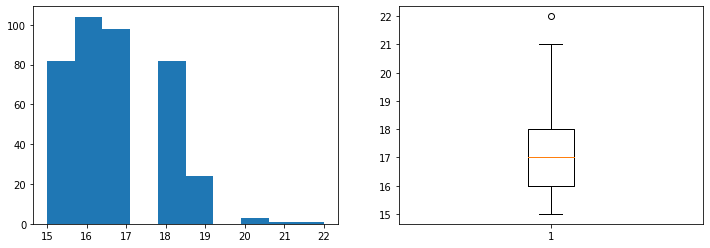

In [86]:
# Этот столбец числовой 
print('Количество строк в которых не указаны данные -', 
      len(stud_df[stud_df['age'].isnull()]['age'].values))
print('Количество учеников старше 21 года -', stud_df[stud_df['age'] > 21].count()[0])
print('Количество учеников 16-18 лет -', stud_df[(stud_df['age'] >= 16) & (stud_df['age'] <= 18)].count()[0])

# Посмотрим на его распределение:
display(stud_df['age'].describe())
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(stud_df['age'])
axes[1].boxplot(stud_df['age'])

Основное кол-во учеников в возрасте 16-18 лет (284 чел.), есть выброс 1 ученик ввозрастом 22 года.

#### 2.4 столбец citizen (городской житель)

In [87]:
not_numeric_column_information(stud_df, 'citizen')

Количество строк в которых не указаны данные - 17


count  percent
school citizen                
GP     False       60    15.87
       True       277    73.28
MS     False       23     6.08
       True        18     4.76

Большинство учеников являются городскими жителями (78%). <br>
Большая часть (277/337 = 82.2%) учеников школы <b>GP</b> - городские жители. <br>
Большая часть (23/41 = 56.1%) учеников школы <b>MS</b> - <b>НЕ</b> горожане. <br>
Так же видно, что из школы <b>MS</b> представленно меньшее кол-во данных по ученикам (41 против 337 в GP).
<br><br>
Из этого можно сделать вывод - школа <b>MS</b> расположена в малонаселенном месте (вне города или на окраине).

#### 2.5 столбец small_family (семья <= 3 человек)

In [88]:
not_numeric_column_information(stud_df, 'small_family')

# посмотрим размер семьи в разрезе проживания (город/не город)
display(stud_df[['school', 'citizen', 'small_family', 'age']].groupby([
    'school', 'citizen', 'small_family'
]).count().rename(
    columns={'age': 'count'}
))

Количество строк в которых не указаны данные - 27


count  percent
school small_family                
GP     False           233    63.32
       True             91    24.73
MS     False            28     7.61
       True             16     4.35

count
school citizen small_family       
GP     False   False            42
               True             13
       True    False           185
               True             73
MS     False   False            16
               True              5
       True    False             8
               True             10

Большинство (71%) представленных учеников проживают в семьях боллее 3-х человек. Если сделать выборку в разрезе того в городе или нет проживает семья, видно что размер семьи больше у городских. Однако есть отклонение - городские семьи дети которых учатся в школе MS в большинстве имеют меньшую численность (10 против 8).

#### 2.6 столбец parents_together (родители проживают вместе)

In [89]:
not_numeric_column_information(stud_df, 'parents_together')

Количество строк в которых не указаны данные - 45


count  percent
school parents_together                
GP     False                34     9.71
       True                272    77.71
MS     False                 2     0.57
       True                 42    12.00

В большинстве семей (90%) родители живут вместе

#### 2.7 столбец mother_edu (образование матери)

Образование матери
0 - нет
1 - 4 класса
2 - 5-9 классы
3 - среднее специальное или 11 классов
4 - высшее
-------------------

Количество строк в которых не указаны данные - 3


count  percent
school mother_edu                
GP     0.0             3     0.77
       1.0            42    10.71
       2.0            95    24.23
       3.0            86    21.94
       4.0           120    30.61
MS     1.0            17     4.34
       2.0             7     1.79
       3.0            11     2.81
       4.0            11     2.81

<AxesSubplot:>

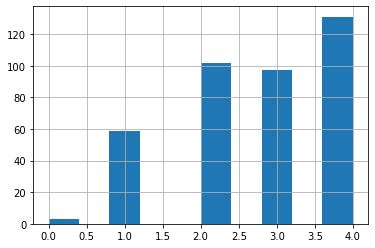

In [90]:
print('Образование матери')
print('0 - нет')
print('1 - 4 класса')
print('2 - 5-9 классы')
print('3 - среднее специальное или 11 классов')
print('4 - высшее')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'mother_edu')
# Посмотрим на распределение:
display(stud_df['mother_edu'].hist())

Большая часть матерей имеют высшее образование (33.4%). Однако в школе MS большинство (4.3%) имеют образование 4 класса

In [91]:
# Возможно есть смысл посмотреть как соотносятся данные о проживании ученика (citizen = True/False) и образования его матери
count = len(stud_df[pd.notnull(stud_df['mother_edu'])]['mother_edu'].values)
buffer = stud_df[['citizen', 'mother_edu', 'age']].groupby([
    'citizen', 'mother_edu'
]).count().rename(
    columns={'age': 'count'}
)
buffer['percent'] = buffer['count'].apply(lambda x: round(x/count * 100, 2))
display(buffer)

count  percent
citizen mother_edu                
False   1.0            20     5.10
        2.0            23     5.87
        3.0            23     5.87
        4.0            16     4.08
True    0.0             3     0.77
        1.0            37     9.44
        2.0            74    18.88
        3.0            72    18.37
        4.0           108    27.55

У учеников проживающих в городе, матери чаще всего имеют высшее образование.

#### 2.8 столбец father_edu (образование отца)

In [92]:
# В данных есть неверно вписанное значение 40 вместо 4 - исправим это
stud_df['father_edu'] = stud_df['father_edu'].apply(lambda x: 4 if x == 40 else x)

Образование отца
0 - нет
1 - 4 класса
2 - 5-9 классы
3 - среднее специальное или 11 классов
4 - высшее
-------------------

Количество строк в которых не указаны данные - 24


count  percent
school father_edu                
GP     0.0             2     0.54
       1.0            63    16.98
       2.0            95    25.61
       3.0            86    23.18
       4.0            81    21.83
MS     1.0            15     4.04
       2.0            11     2.96
       3.0            10     2.70
       4.0             8     2.16

<AxesSubplot:>

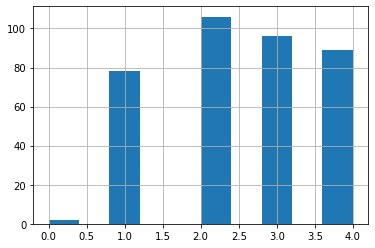

In [93]:
print('Образование отца')
print('0 - нет')
print('1 - 4 класса')
print('2 - 5-9 классы')
print('3 - среднее специальное или 11 классов')
print('4 - высшее')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'father_edu')
# Посмотрим на распределение:
display(stud_df['father_edu'].hist())

Большая часть отцов (28.6%) имеют образование 5-9 класса. Однако в школе MS большинство (4.04%) имеют образование 4 класса

#### 2.9 столбец mother_job (место работы матери)

In [94]:
not_numeric_column_information(stud_df, 'mother_job')

Количество строк в которых не указаны данные - 19


count  percent
school mother_job                
GP     at_home        48    12.77
       health         30     7.98
       other         114    30.32
       services       89    23.67
       teacher        49    13.03
MS     at_home        10     2.66
       health          2     0.53
       other          19     5.05
       services        9     2.39
       teacher         6     1.60

Т.к. тип работы other нам даёт мало информации, не будем здесь его учитывать.<br> 
Из приведенных данных можно заметить: <br>
- для школы <b>GP</b> большинство (23.67%) матерей работают в сфере услуг (services).
- для школы <b>MS</b> большинство (2.66%) матерей - домохозяйки (at_home).

In [95]:
# посмотрим данные по виду деятельности матери в разрезе её образования
display(stud_df[['mother_edu', 'mother_job', 'age']].groupby([
    'mother_edu', 'mother_job'
]).count().rename(
    columns={'age': 'count'}
))

count
mother_edu mother_job       
0.0        at_home         2
           other           1
1.0        at_home        25
           health          1
           other          26
           services        5
2.0        at_home        21
           health          2
           other          45
           services       30
3.0        at_home         8
           health          5
           other          37
           services       38
           teacher         3
4.0        at_home         2
           health         24
           other          22
           services       24
           teacher        52

Так же интересно посмотреть данные в разрезе образования матерей. 
<br>Видно что домохозяйки (at_home) - это в основном матери без высшего образования.<br>
Тогда как имеющие высшее образование чаще работают в сфере услуг (services), здравоохранения (health) и образования (teacher)<br>
<br>
<i>Мне кажется образование и деятельность родителей имеет связь с оценкой по экзамену для школьника.</i>

#### 2.10 столбец father_job (место работы отца)

In [96]:
not_numeric_column_information(stud_df, 'father_job')

Количество строк в которых не указаны данные - 36


count  percent
school father_job                
GP     at_home        13     3.62
       health         15     4.18
       other         180    50.14
       services       83    23.12
       teacher        27     7.52
MS     at_home         3     0.84
       other          17     4.74
       services       19     5.29
       teacher         2     0.56

Из приведенных данных можно заметить: <br>
1. кол-во не заполненных данных уже 36 против 19 для матерей. Так же большинство (54.88%) отцов указывают вид деятельности как other
- возможно, это говорит о том, что отцы реже расположены раскрывать информацию о своей деятельности
2. если не учитывать вид деятельности other, то для обеих школ <b>GP</b> и <b>MS</b> большинство (28.41%) отцов работают в сфере услуг (services).

In [97]:
# посмотрим данные по виду деятельности отца в разрезе его образования
display(stud_df[['father_edu', 'father_job', 'age']].groupby([
    'father_edu', 'father_job'
]).count().rename(
    columns={'age': 'count'}
))

count
father_edu father_job       
0.0        other           2
1.0        at_home         3
           health          1
           other          48
           services       19
2.0        at_home         6
           health          1
           other          58
           services       27
3.0        at_home         3
           health          3
           other          51
           services       31
           teacher         1
4.0        at_home         2
           health          8
           other          31
           services       17
           teacher        25

Отцы с высшим образованием чаще работают в сфере услуг (services), здравоохранения (health) и образования (teacher) чем отцы без высшего образования.<br> И всё же во всех группах доминирует вид деятельности other, даже для людей с высшим образованием

#### 2.11 столбец reason (причина выбора школы)

In [98]:
# ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
print('причина выбора школы')
print('-------------------')
print('home - близость к дому')
print('reputation -  репутация школы')
print('course - образовательная программа')
print('other - другое')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'reason')

причина выбора школы
-------------------
home - близость к дому
reputation -  репутация школы
course - образовательная программа
other - другое
-------------------

Количество строк в которых не указаны данные - 17


count  percent
school reason                    
GP     course        119    31.48
       home           94    24.87
       other          25     6.61
       reputation     98    25.93
MS     course         18     4.76
       home           10     2.65
       other           9     2.38
       reputation      5     1.32

Большая часть учащихся (36.24%) выбирали школы исхдя из образовательной программы. <br><br>
Следующие по "рейтингу" критерии разделились не однозначно:
- Для учащихся школы <b>GP</b> репутация школы важнее чем близость к дому (25.93% против 24.87%)<br>
- Для учащихся школы <b>MS</b> близость к дому оказывается более выжным фактором, чем её репутация (2.65% против 1.32%)

#### 2.12 столбец guardian (опекун) 

In [100]:
not_numeric_column_information(stud_df, 'guardian')

Количество строк в которых не указаны данные - 31


count  percent
school guardian                
GP     father       75    20.60
       mother      226    62.09
       other        25     6.87
MS     father       11     3.02
       mother       24     6.59
       other         3     0.82

В подавляющем большинстве случаев опекунами учеников являются матери.

#### 2.13 столбец travel_time (время в пути до школы)

время в пути до школы
-------------------
1 - <15 мин.
2 - 15-30 мин.
3 - 30-60 мин.
4 - >60 мин.
-------------------

Количество строк в которых не указаны данные - 28


count  percent
school travel_time                
GP     1.0            229    62.40
       2.0             76    20.71
       3.0             14     3.81
       4.0              6     1.63
MS     1.0             13     3.54
       2.0             20     5.45
       3.0              8     2.18
       4.0              1     0.27

<AxesSubplot:>

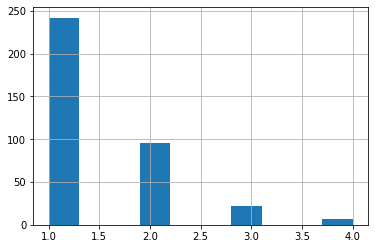

In [101]:
print('время в пути до школы')
print('-------------------')
print('1 - <15 мин.')
print('2 - 15-30 мин.')
print('3 - 30-60 мин.')
print('4 - >60 мин.')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'travel_time')
# Посмотрим на распределение:
display(stud_df['travel_time'].hist())

Большинство учеников (92,1%) добираются до школы менее чем за 30 минут <br>
Так же можно заметить, что для школы <b>MS</b> больше учеников добираются до неё за 15-30 мин. (20 человек. - 47.62% (20/42)) <br>
В школе <b>GP</b> большинство добираются меньше чем за 15 мин. (229 чел. - 71.46% (229/325))<br><br>
Что ещё раз может нам говорить о местоположении школы <b>MS</b> - расположена дальше обычного от учеников (см. пункт 2.3)

#### 2.14 столбец study_time (время на учёбу помимо школы в неделю)

время на учёбу помимо школы в неделю
-------------------
1 - <2 часов
2 - 2-5 часов
3 - 5-10 часов
4 - >10 часов
-------------------

Количество строк в которых не указаны данные - 7


count  percent
school study_time                
GP     1.0            87    22.42
       2.0           172    44.33
       3.0            56    14.43
       4.0            27     6.96
MS     1.0            16     4.12
       2.0            22     5.67
       3.0             8     2.06

<AxesSubplot:>

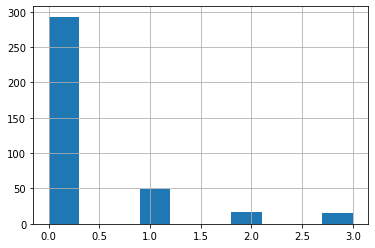

In [102]:
print('время на учёбу помимо школы в неделю')
print('-------------------')
print('1 - <2 часов')
print('2 - 2-5 часов')
print('3 - 5-10 часов')
print('4 - >10 часов')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'study_time')
# Посмотрим на распределение:
display(stud_df['failures'].hist())

Оснавная масса учеников тратит дополнительное время на обучение до 5 часов в неделю 76.54%.<br> При этом в школе <b>GP</b> есть ученики (27/342 = 7.89%), которые трятят на занятия более 10 часов, в школе <b>MS</b> таких нет совсем.

#### 2.15 столбец failures (количество внеучебных неудач)

количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
Количество строк в которых не указаны данные - 22


count  percent
school failures                
GP     0.0         261    69.97
       1.0          40    10.72
       2.0          13     3.49
       3.0          13     3.49
MS     0.0          32     8.58
       1.0           9     2.41
       2.0           3     0.80
       3.0           2     0.54

<AxesSubplot:>

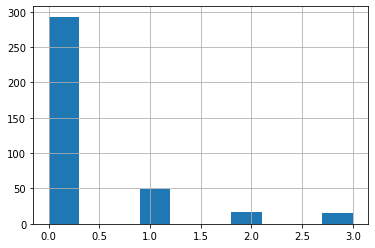

In [103]:
print('количество внеучебных неудач (n, если 1<=n<=3, иначе 0)')

not_numeric_column_information(stud_df, 'failures')
# Посмотрим на распределение:
display(stud_df['failures'].hist())

Большинство учащихся (78.55%) не имеют неудач.

#### 2.16 столбец school_support (дополнительная образовательная поддержка)

In [104]:
# Опять же о какой поддержке идёт речь? Материальная или дополнительные образовательные часы?
not_numeric_column_information(stud_df, 'school_support')

Количество строк в которых не указаны данные - 9


count  percent
school school_support                
GP     False             291    75.39
       True               51    13.21
MS     False              44    11.40

Всего такую поддержку получают 13.21% учеников, инетересно, что такое практикуют только в школе <b>GP</b>.

#### 2.17 столбец family_support (семейная образовательная поддержка)

In [105]:
# Выведем стандартное представление для нечисловые данных
not_numeric_column_information(stud_df, 'family_support')

Количество строк в которых не указаны данные - 39


count  percent
school family_support                
GP     False             109    30.62
       True              202    56.74
MS     False              28     7.87
       True               17     4.78

Видно, что такую поддержку получают большинство учеников в школе <b>GP</b> (202/311 = 64.95%), в школе <b>MS</b> поддержку получает лишь (17/45 = 37,78%)<br>
Из анализа текущего и предыдущего столбца можно заключить, что ученикам школы <b>MS</b> не приходится надеяться на поддержку.

#### 2.18 столбец paid (дополнительные платные занятия по математике)

In [106]:
not_numeric_column_information(stud_df, 'paid')

Количество строк в которых не указаны данные - 40


count  percent
school paid                 
GP     False    174    49.01
       True     138    38.87
MS     False     26     7.32
       True      17     4.79

Дополнительные платные занятия достаточно популярны, их практикуют 43,66% учащихся. Интересно, есть ли от этого эффект на результат экзамена.

In [107]:
# Возможно есть смысл посмотреть как получают дополнительные занятия ученики проживающие в городе (citizen = True) и за городом.
count = len(stud_df[pd.notnull(stud_df['paid'])]['paid'].values)
buffer = stud_df[['citizen', 'paid', 'age']].groupby([
    'citizen', 'paid'
]).count().rename(
    columns={'age': 'count'}
)
buffer['percent'] = buffer['count'].apply(lambda x: round(x/count * 100, 2))
display(buffer)

count  percent
citizen paid                 
False   False     45    12.68
        True      28     7.89
True    False    147    41.41
        True     119    33.52

Горожане чаще получают платные занятия по математики (119/226 = 44.73%), чем не городские жители (28/73 = 38.36%)

#### 2.19 столбец activities (дополнительные внеучебные занятия)

In [109]:
not_numeric_column_information(stud_df, 'activities')

Количество строк в которых не указаны данные - 14


count  percent
school activities                
GP     False         157    41.21
       True          179    46.98
MS     False          29     7.61
       True           16     4.20

Большая часть учеников школы <b>GP</b> (179/336 = 53.27%) участвуют во внеучебных занятиях, в отличие от школы <b>MS</b> там таких только (16/45 = 35.56%)

#### 2.20 столбец nursery (посещал детский сад)

In [110]:
not_numeric_column_information(stud_df, 'nursery')

Количество строк в которых не указаны данные - 16


count  percent
school nursery                
GP     False       65    17.15
       True       272    71.77
MS     False       14     3.69
       True        28     7.39

Подавляющее большинство учеников (79.16%) посещали детский сад, такая картина видна в обеих школах.

#### 2.21 столбец higher (хочет получить высшее образование)

In [111]:
not_numeric_column_information(stud_df, 'higher')

Количество строк в которых не указаны данные - 20


count  percent
school higher                
GP     False      16     4.27
       True      316    84.27
MS     False       3     0.80
       True       40    10.67

94.9% учеников настроены на постепление в ВУЗы.

#### 2.22 столбец internet (наличие интернета дома)

In [112]:
not_numeric_column_information(stud_df, 'internet')

Количество строк в которых не указаны данные - 34


count  percent
school internet                
GP     False        45    12.47
       True        273    75.62
MS     False        11     3.05
       True         32     8.86

С доступом в internet у большинства всё в порядке, его имеют 84.5% учеников. Однако странно, что 15.5% учеников интернета не имеют, процент не маленький.

#### 2.23 столбец romantic (в романтических отношениях)

In [113]:
not_numeric_column_information(stud_df, 'romantic')

Количество строк в которых не указаны данные - 31


count  percent
school romantic                
GP     False       215    59.07
       True        106    29.12
MS     False        25     6.87
       True         18     4.95

Ученики в романтических отнашениях в меньшинстве - 34.07%

#### 2.24 столбец family_relationships (семейные отношения)

In [114]:
# попались данные со значением -1 (что ошибочно), будем считать, что имеется ввиду - 1. Внесем правку.
stud_df['family_relationships'] = stud_df['family_relationships'].apply(lambda x: 1 if x == -1 else x)

семейные отношения
-------------------
от 1 - очень плохо до 5 - очень хорошо
-------------------

Количество строк в которых не указаны данные - 27


count  percent
school family_relationships                
GP     1.0                       6     1.63
       2.0                      15     4.08
       3.0                      54    14.67
       4.0                     164    44.57
       5.0                      87    23.64
MS     1.0                       2     0.54
       2.0                       2     0.54
       3.0                       8     2.17
       4.0                      18     4.89
       5.0                      12     3.26

count    368.000000
mean       3.942935
std        0.903824
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: family_relationships, dtype: float64

<AxesSubplot:>

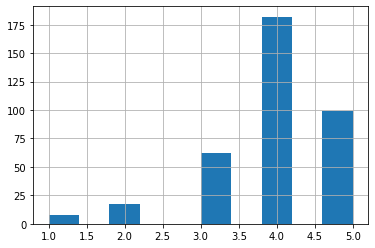

In [117]:
print('семейные отношения')
print('-------------------')
print('от 1 - очень плохо до 5 - очень хорошо')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'family_relationships')
# Посмотрим на распределение:
display(stud_df['family_relationships'].describe())
display(stud_df['family_relationships'].hist())

<AxesSubplot:>

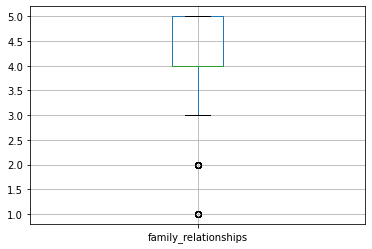

In [118]:
display(stud_df.boxplot(column=['family_relationships']))

Оснавная масса учеников имеют хорошие отношения в семье (оценка 4-5), оценки 1, 2 можно считать выбросами.

#### 2.25 столбец free_time (свободное время после школы)

свободное время после школы
-------------------
от 1 - очень мало до 5 - очень мого
-------------------

Количество строк в которых не указаны данные - 11


count  percent
school free_time                
GP     1.0           16     4.17
       2.0           54    14.06
       3.0          139    36.20
       4.0           98    25.52
       5.0           31     8.07
MS     1.0            2     0.52
       2.0            9     2.34
       3.0           14     3.65
       4.0           14     3.65
       5.0            7     1.82

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: free_time, dtype: float64

<AxesSubplot:>

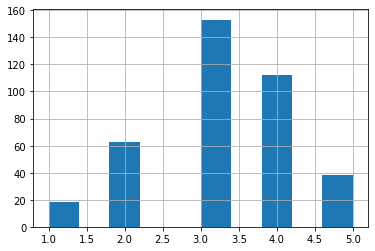

In [119]:
print('свободное время после школы')
print('-------------------')
print('от 1 - очень мало до 5 - очень мого')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'free_time')
# Посмотрим на распределение:
display(stud_df['free_time'].describe())
display(stud_df['free_time'].hist())

<AxesSubplot:>

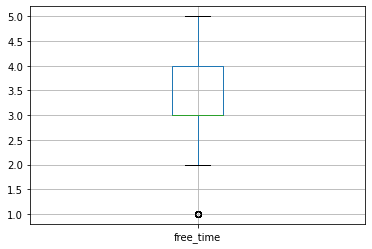

In [120]:
display(stud_df.boxplot(column=['free_time']))

Большинство учеников трятят много времени на отдых после школы (оценка 3-4), оценку 1 можно считать выбросом.

#### 2.26 столбец go_out (проведение времени с друзьями)

проведение времени с друзьями
-------------------
от 1 - очень мало до 5 - очень много
-------------------

Количество строк в которых не указаны данные - 8


count  percent
school go_out                
GP     1.0        20     5.17
       2.0        91    23.51
       3.0       110    28.42
       4.0        72    18.60
       5.0        48    12.40
MS     1.0         3     0.78
       2.0        10     2.58
       3.0        17     4.39
       4.0        12     3.10
       5.0         4     1.03

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: go_out, dtype: float64

<AxesSubplot:>

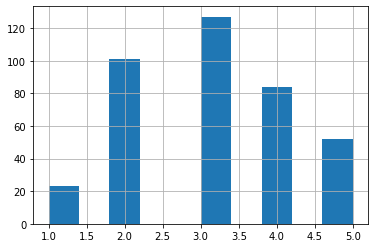

In [121]:
print('проведение времени с друзьями')
print('-------------------')
print('от 1 - очень мало до 5 - очень много')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'go_out')
# Посмотрим на распределение:
display(stud_df['go_out'].describe())
display(stud_df['go_out'].hist())

<AxesSubplot:>

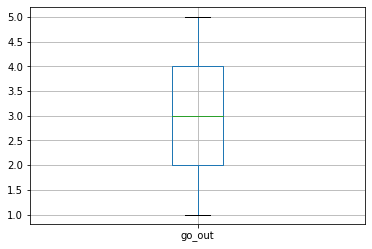

In [122]:
display(stud_df.boxplot(column=['go_out']))

В целом ученики проводят достаточно времени с друзьями основные оценки 2-4, без выбросов.

#### 2.27 столбец health (текущее состояние здоровья) 

текущее состояние здоровья
-------------------
от 1 - очень плохо до 5 - очень хорошо
-------------------

Количество строк в которых не указаны данные - 15


count  percent
school health                
GP     1.0        40    11.98
       2.0        38    11.38
       3.0        76    22.75
       4.0        58    17.37
       5.0       122    36.53

Количество строк в которых не указаны данные - 0


count  percent
school health                
MS     1.0         7    15.22
       2.0         5    10.87
       3.0        13    28.26
       4.0         5    10.87
       5.0        16    34.78

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

<AxesSubplot:>

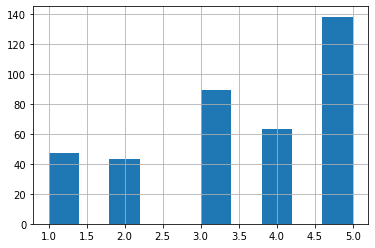

In [123]:
print('текущее состояние здоровья')
print('-------------------')
print('от 1 - очень плохо до 5 - очень хорошо')
print('-------------------')
print('')
not_numeric_column_information(stud_df, 'health', ['GP'])
not_numeric_column_information(stud_df, 'health', ['MS'])
# Посмотрим на распределение:
display(stud_df['health'].describe())
display(stud_df['health'].hist())

<AxesSubplot:>

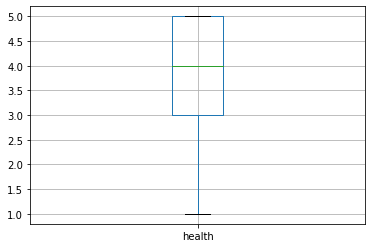

In [124]:
display(stud_df.boxplot(column=['health']))

Основное кол-во учеников имеют удовлетворительное состояние здоровья оценки 3 - 5, это 76.6% в <b>GP</b> и 73.9% в <b>MS</b>. <br>
Однако, я считаю, что процент учеников с плохим здоровьем - 23.4% и 26.1%, достаточно высокое.

#### 2.28 столбец absences (количество пропущенных занятий)

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

<AxesSubplot:>

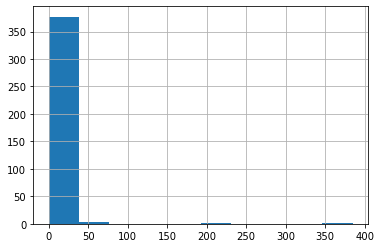

In [125]:
# Посмотрим на распределение:
display(stud_df['absences'].describe())
display(stud_df['absences'].hist())

<AxesSubplot:>

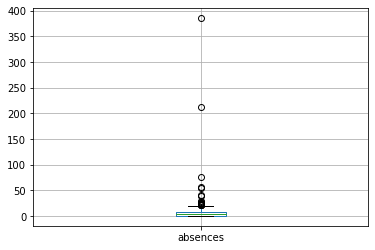

In [126]:
display(stud_df.boxplot(column=['absences']))

Здесь имеются экстремальные выбросы (385 пропущенных занятий), мне кажется от таких данных стоит избавиться.

IQR = 8.0
25-й перцентиль = 0.0
75-й перцентиль = 8.0
Границы выбросов: [-12.0, 20.0].


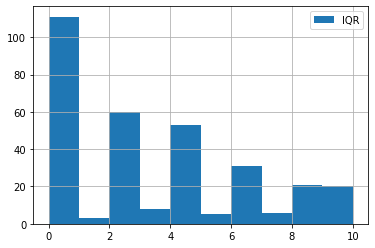

In [127]:
# Этот способ позволил нам отобрать экстремально низкие и экстремально высокие значения. 
IQR = stud_df['absences'].quantile(0.75) - stud_df['absences'].quantile(0.25)
perc25 = stud_df['absences'].quantile(0.25)
perc75 = stud_df['absences'].quantile(0.75)
print('IQR =', IQR)
print('25-й перцентиль =', perc25)
print('75-й перцентиль =', perc75)
print("Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

stud_df['absences'].loc[stud_df['absences'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR')
plt.legend();

In [129]:
# Отфильтруем данные:
stud_df = stud_df.loc[stud_df['absences'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

count    366.000000
mean       4.603825
std        4.965512
min        0.000000
25%        0.000000
50%        4.000000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

<AxesSubplot:>

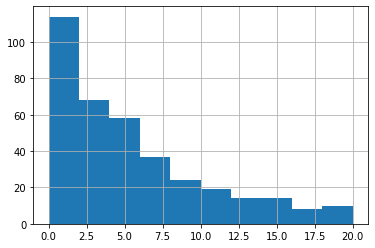

In [130]:
# Посмотрим на распределение:
display(stud_df['absences'].describe())
display(stud_df['absences'].hist())

<AxesSubplot:>

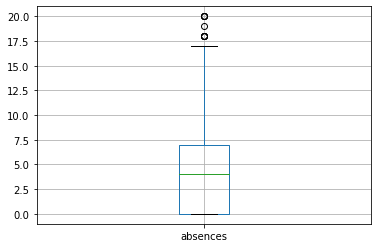

In [131]:
display(stud_df.boxplot(column=['absences']))

Уже выглядит лучше. Теперь можно сказать, что оснавная масса учеников пропустила не больше 7 занятий, максимум 20, что вполне приемлимо, т.к. больничные никто не отменял :)

#### 2.29 столбец score (баллы по госэкзамену по математике)

Выжный столбец, т.к. наша цель выявление учеников готовых потенциально не справиться с экзаменом.

count    361.000000
mean      51.994460
std       22.956117
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

<AxesSubplot:>

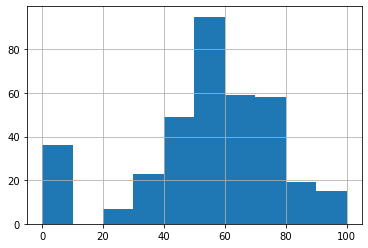

In [132]:
# Посмотрим на распределение:
display(stud_df['score'].describe())
display(stud_df['score'].hist())

<AxesSubplot:>

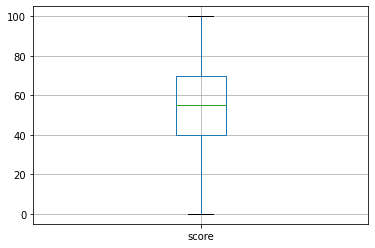

In [133]:
display(stud_df.boxplot(column=['score']))

Можно увидеть, что основные баллы распределены в рамках 40-70, выбросов нет.

#### 2.30 столбец studytime_granular

In [134]:
# т.к. никакой информации об этом столбце нет, он не несёт полезной нагрузки, для анализа. Столбец удаляю.
stud_df.drop(['studytime_granular'], inplace = True, axis = 1)

### 3 корреляционный анализ количественных переменных

<AxesSubplot:>

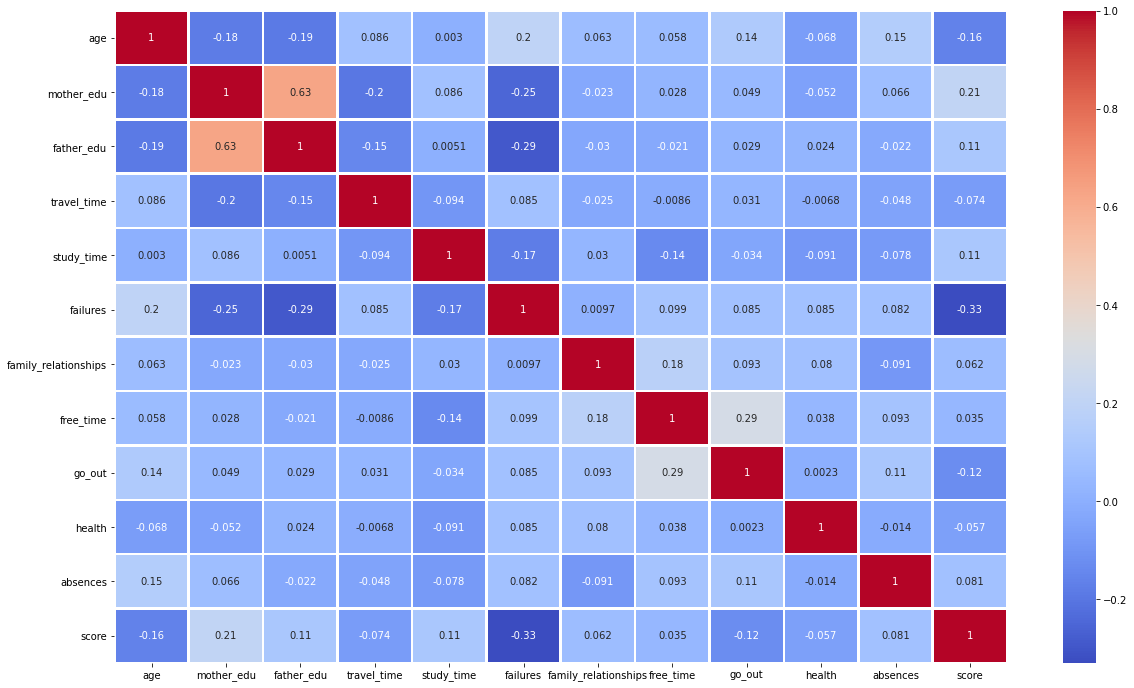

In [135]:
# Отберём подходящие столбцы для корреляционного анализа
for_corr = stud_df[[
    'age', 'mother_edu', 'father_edu', 'travel_time', 
    'study_time', 'failures', 'family_relationships', 
    'free_time', 'go_out', 'health', 'absences', 'score'
]]
# Для анализа корреляции используем heatmap
plt.figure(figsize = (20,12))
correlation_mat = for_corr.corr()
sns.heatmap(correlation_mat, annot=True, linewidths=1.5, cmap = 'coolwarm')

Выберем столбцы с коэффициентами >= 0.1.<br> 
Это mother_edu, father_edu и study_time с коэффициентами 0.21, 0.11, 0.11.<br>
И failures, age, go_out -0.33, -0.16, -0.12.<br>
В принципе все параметры логически оправданы, кроме, age, возможно более старшие ученики подрабатывают, значит меньше времени тратят на дополнительное обучение.

<b>Так же проведем корреляционный анализ для данных типа boolean, предварительно проранжировав значения (False = 1, True = 2)</b>

In [136]:
bool_col = [
    'female', 'citizen', 'small_family', 'parents_together', 
    'school_support', 'family_support', 'paid', 
    'activities', 'nursery', 'higher', 'internet', 'romantic', 'school',
    'score'
]
map_list = [
    ['female','F','M'], ['citizen','U','R'], ['small_family','LE3','GT3'],
    ['parents_together','T','A'], ['school_support','yes','no'], ['family_support','yes','no'],
    ['paid','yes','no'], ['activities','yes','no'], ['nursery','yes','no'],
    ['higher','yes','no'], ['internet','yes','no'], ['romantic','yes','no']
]

# Отберём столбцы типа boolean и столбец score, для которого будем сравнивать значения
for_bool_corr = stud_df[bool_col]

print('Приведение данных bool к типу number, результат -', data_frame_columns_to_bool(for_bool_corr, map_list, True))

Приведение данных bool к типу number, результат - True


<ipython-input-79-2ec559a9b214>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[value[0]] = column_data_to_number(data_frame, value[0], value[1], value[2])


<AxesSubplot:>

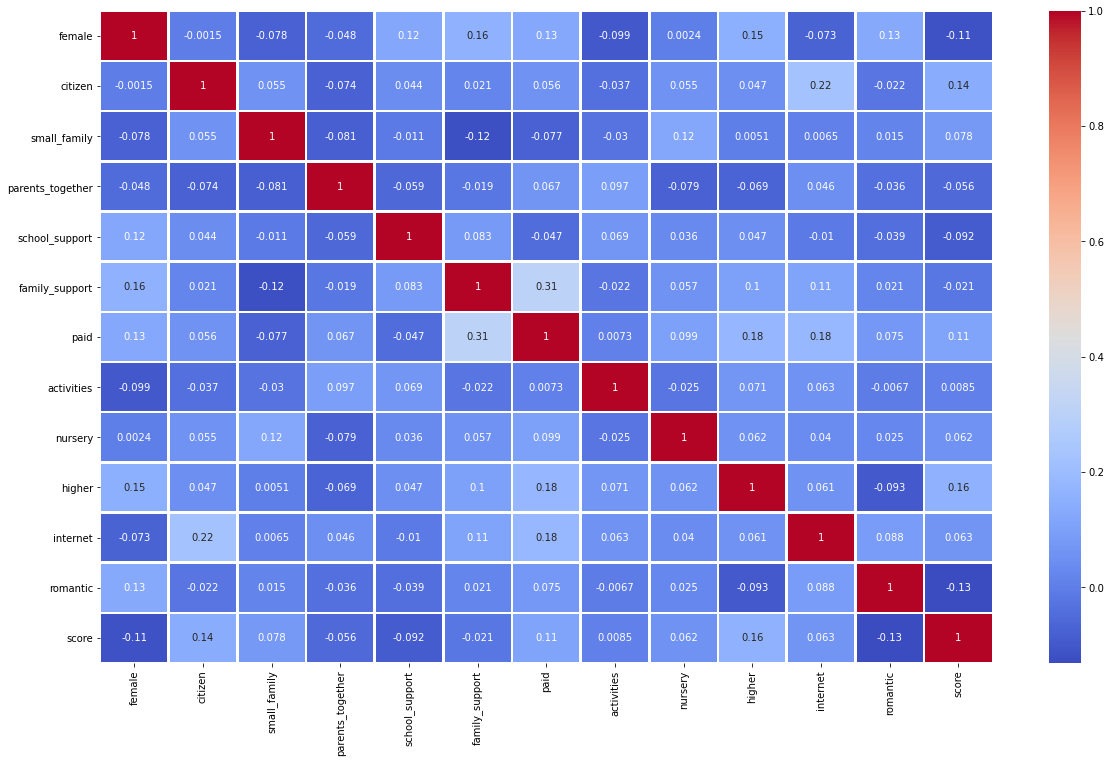

In [138]:
# Для анализа корреляции используем heatmap
plt.figure(figsize = (20, 12))
correlation_mat = for_bool_corr.corr()
sns.heatmap(correlation_mat, annot=True, linewidths=1.5, cmap = 'coolwarm')

Выберем столбцы с коэффициентами >= 0.1, для этого подходят citizen, paid, higher, romantic. <br>
как можно обосновать зависимость этих параметров от score:<br>
citizen - возможно потому что чаще получают дополнительное занятия по математике, образование матери чаще высшее<br>
paid - дополнительные занятия по математики (можно не комментировать)<br>
higher - стремятся получить лучший результат на экзамене, что позитивно скажется при получении высшего образования<br>
romantic - корреляция обратная, вероятно, отвлекаются от обучения и меньше времени посвещают занятиям<br>

### 4 анализ номинативных переменных

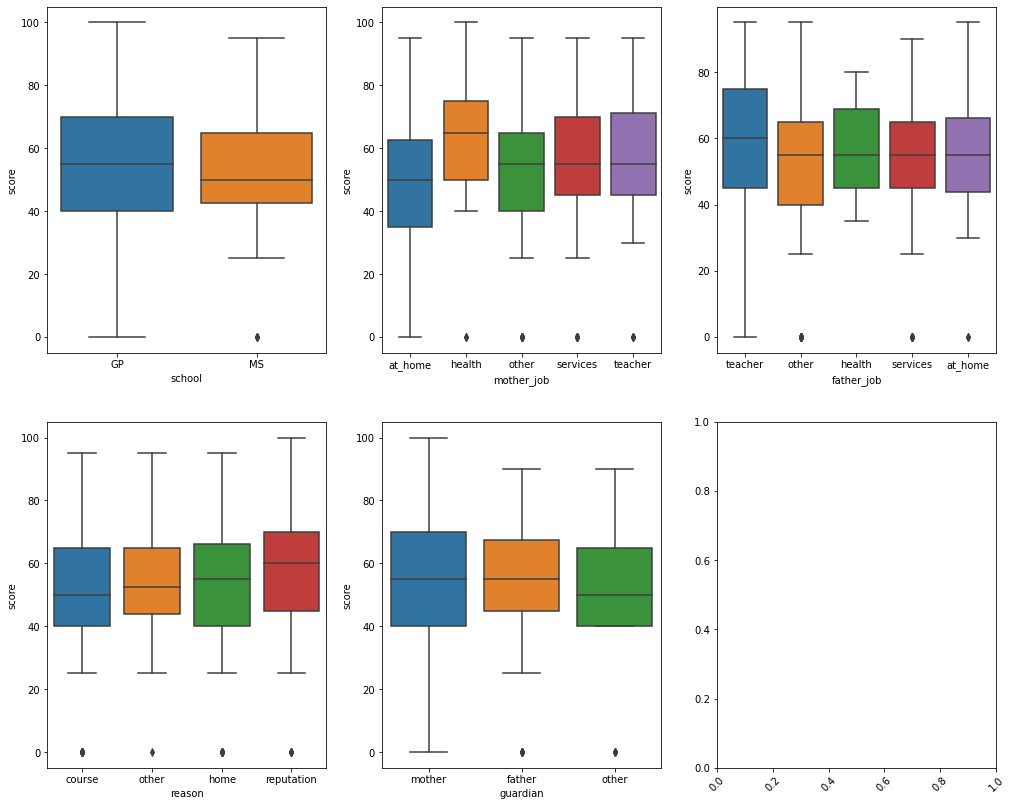

In [148]:
# Отберём оставщиеся не числовые параметры и выведем их на график boxplot
columns = [
    'school', 'mother_job', 'father_job',
    'reason', 'guardian',    
]
get_boxplot(stud_df, columns)

На первый взгляд по графикам выдно, что на результат экзамена могут влиять параметры mother_job, father_job.

In [152]:
# Проверим, есть ли статистическая разница 
# в распределении оценок по номинативным признакам, с помощью теста Стьюдента. 
# Проверим нулевую гипотезу о том, что распределения оценок батончиков по различным 
# параметрам неразличимы:

columns = [
    'school', 'mother_job', 'father_job', 'guardian',    
]

for col in columns:
    get_stat_dif(stud_df, col)

Найдены статистически значимые различия для колонки mother_job


Так же я предлагаю добавить параметр father_job, т.к. для учеников, у которых отец учитель, 
высокий межквартильный размах, по сравнению с отсальными.

### Выводы

- в каждой колонке есть пропущенные значения (но их величина не критична)
- есть столбец без описания (studytime, granular) не несущий пользы для анализа
- в датасете представлены ученики 2-х школ городской GP и вне города MS, большая часть учеников обучаются в школе GP
- в столбце absences (пропущенные занятия) есть значительные выбросы
- Корреляционный анализ числовых параметров показал, что бОльшую положительную связь показывают параметры <b>mother_edu</b>, <b>father_edu</b> и <b>study_time</b>, отрицательную связь <b>failures</b>, <b>age</b>, <b>go_out</b>
- анализ параметров типа boolean показал, что на параметр успешной сдачи экзамена по математики оказывают параметры <b>citizen</b>, <b>paid</b>, <b>higher</b>, <b>romantic</b>
- анализ номинативных параметров показал, что на результат сдачи экзамена оказывают место работы родителей <b>mother_job</b>, <b>father_job</b>

Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, 
это <b>mother_edu</b>, <b>father_edu</b>, <b>study_time</b>, <b>failures</b>, <b>age</b>, <b>go_out</b>, 
<b>citizen</b>, <b>paid</b>, <b>higher</b>, <b>romantic</b>, <b>mother_job</b>, <b>father_job</b>.